### Сбор данных и динамический анализ позиций в поиске по артикулам для определенныого бренда на Вб в разрезе городов и запросов

__Цель:__ написать код, котрый будет отслеживать позиции в поиске ВБ в режиме реального времени (при запуске блокнота), в зависимости от города, запроса и количества страниц. Автоматизировать сбор данных, наглядно показать результаты. 

Данная работа поможет менеджеру бренда своевременно заметить выпад в поиске с первых страниц,  с конкретных городов или запросов, отследить резкие изменения позиций и своевременно приниять меры.

Для исследования были выбраны:
- ниша - купальники для гимнастики
- бренд 'НОЛА'
- города: Москва, Санкт-Петербург, Казань, Краснодар, Новосибирск, Екатеринбург (т.к. в этих городах расположены основные региональные склады вб для разных кластеров)
- интересует первая страница

Данные о позициях были получены через открытое API площадки ВБ.

In [1]:
# Импортируем необходимые библиотеки
import requests
from geopy.geocoders import Nominatim
from datetime import datetime, timedelta, date
import random
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [2]:
# Запрсы, по которым будем определять позиции в поиске
query_list=['купальник гимнастический', 'купальник для танцев', 'купальник для хореографии']
# Количество страниц, которые интересуют для просматривания позиций
max_page = 1 
# рассматриваемый бренд 
brand='НОЛА'

In [3]:
# Города, по которым будем смотреть место в поиске
city_list=['Москва', 'Санкт-Петербург', 'Казань', 'Краснодар', 'Новосибирск', 'Екатеринбург']

def generate_city_params(city):
    geolocator=Nominatim(user_agent="my_unique_app_name")
    location=geolocator.geocode(city)

    params = {
        'latitude': location.latitude,
        'longitude': location.longitude,
        'address': city
    }
    city_params= requests.get('https://user-geo-data.wildberries.ru/get-geo-info', params = params)
    return city_params

In [4]:
search_list=[]
# получаем необходимые данные по открытому API ВБ
# цикл по заданным городам
for city in city_list:
    #print(f'\n{city}')
    geo_info=generate_city_params(city)
# цикл по заданным запросам
    for query in query_list:
        #print(f'\nЗапрос:{query}')
        cnt=0
# цикл по заданным страницам
        for page in range(1,max_page+1):
            #print(f'\nстраница {page}')
            res = requests.get(f'''https://search.wb.ru/exactmatch/ru/common/v13/search?ab_testing=false&lang=ru&\
            page={page}&query={query}&resultset=catalog&sort=popular&suppressSpellcheck=false&{geo_info.json()['xinfo']}''')
            products=res.json()['data']['products']
# цикл по товарам заданного бренда
            for product in products:
                cnt+=1
                if product['brand'] == brand:
                    dt=datetime.today()
                    #print(product['id'], product['name'])
                    for size in product['sizes']:
                        search_list.append([dt, query,  city, cnt, product['id'], product['name'], size['name'], size['price']['product']])
                    

In [5]:
# оформим результат в таблицу
import pandas as pd
df=pd.DataFrame(search_list)
df.columns=['date', 'query', 'city', 'position', 'id', 'name', 'size', 'price']
df['price']=round(df['price']/100,0).astype('int')
df['date'] = pd.to_datetime(df['date']).dt.floor('s')
#df

In [6]:
# сгруппируем позиции в поиске по артикулу, запросу и городу
df_group=df.groupby(['id','query','city']).agg({'position':'min', 'price':'mean', 'size':'nunique'})
display(df_group)
df_group=df_group.reset_index()

position   price  size
id        query                     city                                
8881424   купальник гимнастический  Екатеринбург        42   945.0     7
                                    Москва              42   945.0     7
                                    Новосибирск         42   945.0     7
8881425   купальник гимнастический  Екатеринбург        29   945.0     7
                                    Москва              29   945.0     7
                                    Новосибирск         29   945.0     7
          купальник для танцев      Краснодар           47   945.0     7
                                    Москва              47   945.0     7
10743189  купальник гимнастический  Екатеринбург        55  1200.0     7
                                    Москва              55  1200.0     7
                                    Новосибирск         55  1200.0     7
          купальник для танцев      Краснодар           65  1200.0     7
                                    Москва              65  1200.0     7
10743190  купальник гимнастический  Екатеринбург        28  1179.0     7
                                    Москва              28  1179.0     7
                                    Новосибирск         28  1179.0     7
          купальник для танцев      Краснодар           56  1179.0     7
                                    Москва              56  1179.0     7
13254145  купальник гимнастический  Екатеринбург        54   939.0     6
                                    Москва              54   939.0     6
                                    Новосибирск         54   939.0     6
          купальник для хореографии Екатеринбург        88   939.0     6
13254147  купальник для хореографии Екатеринбург        58   560.0     8
13254312  купальник гимнастический  Екатеринбург         3   589.0     7
                                    Москва               3   589.0     7
                                    Новосибирск          3   589.0     7
          купальник для танцев      Краснодар            4   589.0     9
                                    Москва               4   589.0     9
          купальник для хореографии Екатеринбург         9   589.0     8
13254313  купальник для хореографии Екатеринбург        21   702.0    10
13254314  купальник для хореографии Екатеринбург        63   702.0     9
14774445  купальник для танцев      Краснодар           81   900.0     4
                                    Москва              81   900.0     4
162198639 купальник гимнастический  Екатеринбург        67   616.0     6
                                    Москва              67   616.0     6
                                    Новосибирск         67   616.0     6
171597079 купальник для танцев      Краснодар           84   939.0     2
                                    Москва              84   939.0     2
          купальник для хореографии Екатеринбург        85   939.0     2
171604398 купальник гимнастический  Екатеринбург        89   742.0     7
                                    Москва              89   742.0     7
                                    Новосибирск         89   742.0     7
182876074 купальник для хореографии Екатеринбург        78   893.0     7
205031070 купальник гимнастический  Екатеринбург        58   644.0     8
                                    Москва              58   644.0     8
                                    Новосибирск         58   644.0     8
205031075 купальник гимнастический  Екатеринбург        81   673.0     8
                                    Москва              81   673.0     8
                                    Новосибирск         81   673.0     8
205329077 купальник для танцев      Краснодар           22   672.0    10
                                    Москва              22   672.0    10
          купальник для хореографии Екатеринбург        34   672.0    10
205331242 купальник для танцев      Краснодар           98   702.0    10
                                   

In [7]:
for que in query_list:
    # Сводная таблица позиций по городам
    table_city=df_group[df_group['query']==que].pivot_table(index='id', columns='city', values='position',aggfunc='mean').reset_index().round(1)
    print(f'\n{"-"*100}\nСводная таблица позиций по городам по запросу: {que}\n')
    display(table_city)

# Сводная таблица позиций в поиске в зависимости от запроса
table_query=df_group.pivot_table(index='id', columns='query', values='position',aggfunc='mean').reset_index().round(1)
print('\n','='*100,'\nСводная таблица позиций в поиске в зависимости от запроса\n')
display(table_query)

# Сводная таблица цен
table_price=df.groupby(['id'])[[ 'price','position']].mean().head(60).reset_index()
table_price[['price','position']]=table_price[['price','position']].round(2)


----------------------------------------------------------------------------------------------------
Сводная таблица позиций по городам по запросу: купальник гимнастический



city,id,Екатеринбург,Москва,Новосибирск
0,8881424,42.0,42.0,42.0
1,8881425,29.0,29.0,29.0
2,10743189,55.0,55.0,55.0
3,10743190,28.0,28.0,28.0
4,13254145,54.0,54.0,54.0
5,13254312,3.0,3.0,3.0
6,162198639,67.0,67.0,67.0
7,171604398,89.0,89.0,89.0
8,205031070,58.0,58.0,58.0
9,205031075,81.0,81.0,81.0



----------------------------------------------------------------------------------------------------
Сводная таблица позиций по городам по запросу: купальник для танцев



city,id,Краснодар,Москва
0,8881425,47.0,47.0
1,10743189,65.0,65.0
2,10743190,56.0,56.0
3,13254312,4.0,4.0
4,14774445,81.0,81.0
5,171597079,84.0,84.0
6,205329077,22.0,22.0
7,205331242,98.0,98.0



----------------------------------------------------------------------------------------------------
Сводная таблица позиций по городам по запросу: купальник для хореографии



city,id,Екатеринбург
0,13254145,88.0
1,13254147,58.0
2,13254312,9.0
3,13254313,21.0
4,13254314,63.0
5,171597079,85.0
6,182876074,78.0
7,205329077,34.0
8,205331243,29.0



Сводная таблица позиций в поиске в зависимости от запроса



query,id,купальник гимнастический,купальник для танцев,купальник для хореографии
0,8881424,42.0,NaN,NaN
1,8881425,29.0,47.0,NaN
2,10743189,55.0,65.0,NaN
3,10743190,28.0,56.0,NaN
4,13254145,54.0,NaN,88.0
5,13254147,NaN,NaN,58.0
6,13254312,3.0,4.0,9.0
7,13254313,NaN,NaN,21.0
8,13254314,NaN,NaN,63.0
9,14774445,NaN,81.0,NaN


Всего артикулов: 19
Города: ['Москва', 'Санкт-Петербург', 'Казань', 'Краснодар', 'Новосибирск', 'Екатеринбург']


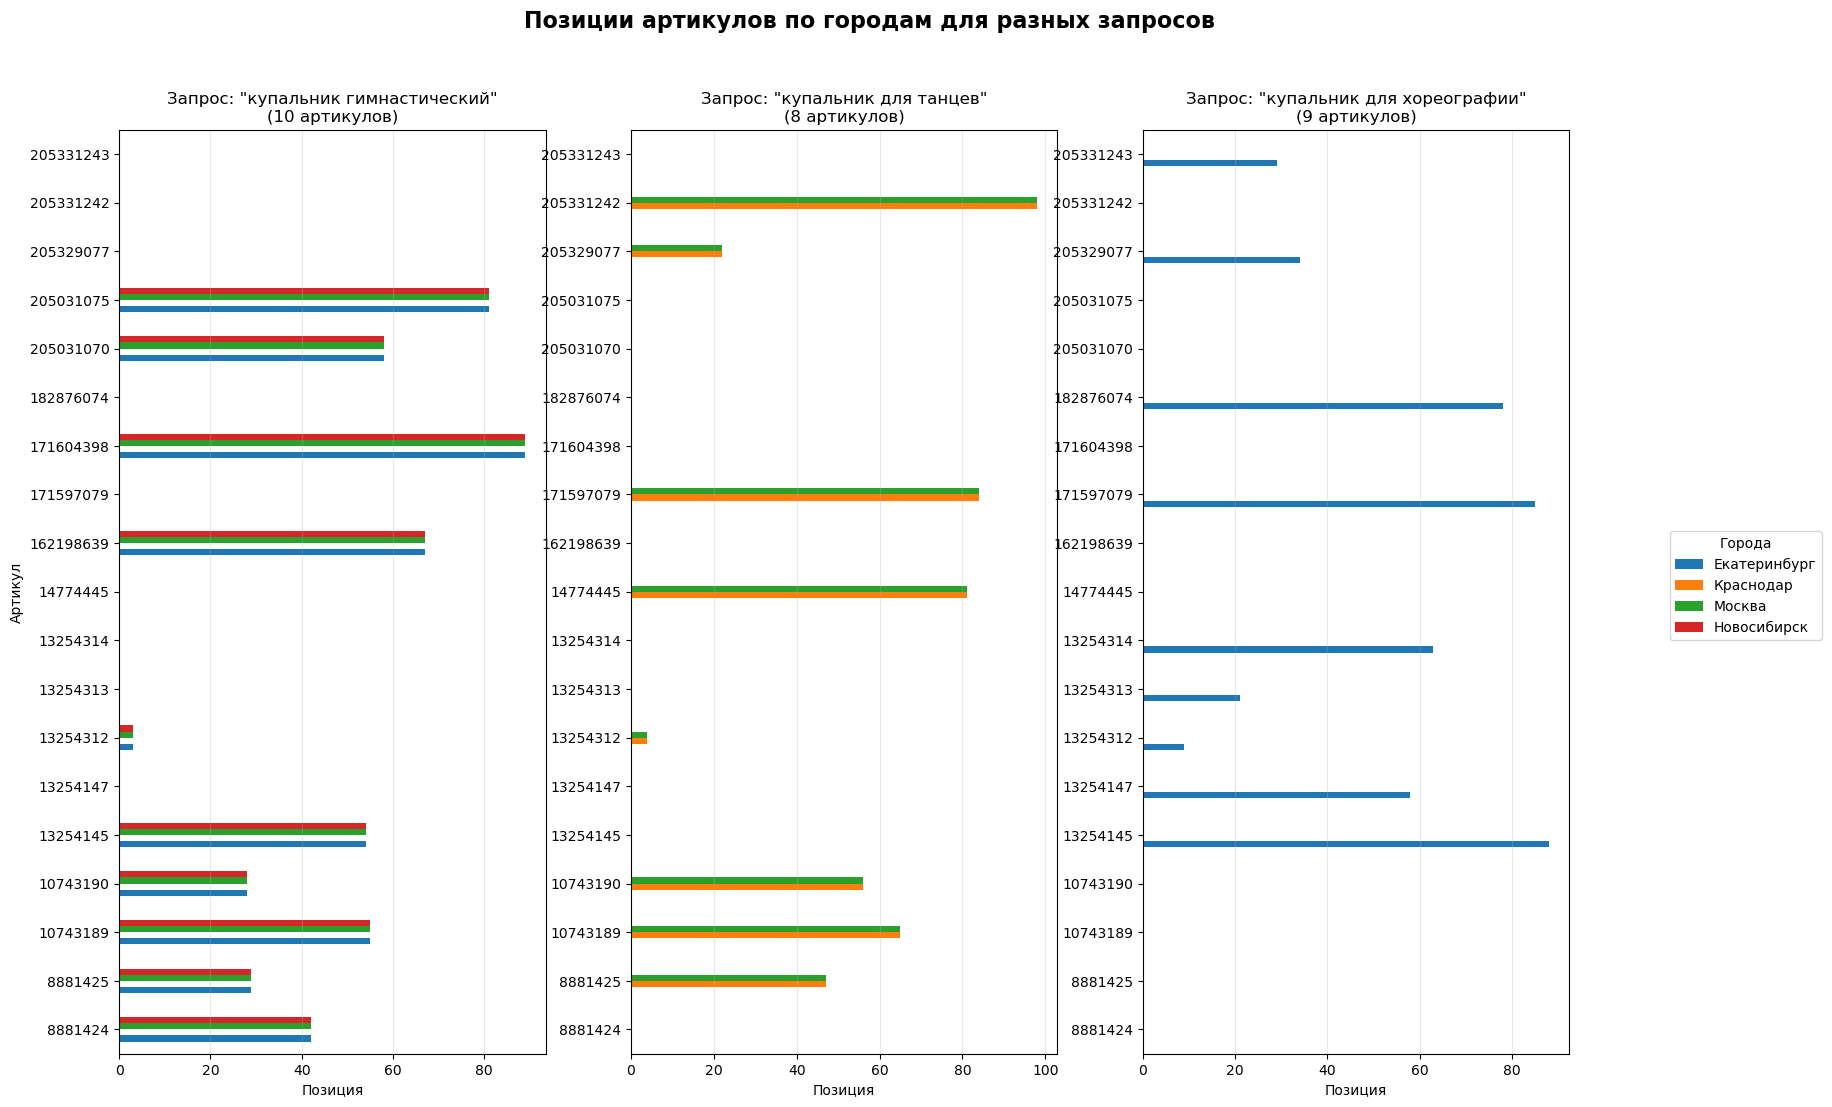

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(20, 12))
fig.suptitle('Позиции артикулов по городам для разных запросов', fontsize=16, fontweight='bold')

# Собираем  артикулы 
all_articles = sorted(df['id'].unique())
all_cities = sorted(df['city'].unique())

print(f"Всего артикулов: {len(all_articles)}")
print(f"Города: {city_list}")

# Строим графики для каждого запроса
for i, query in enumerate(query_list):
    # Фильтруем данные по запросу
    df_query = df[df['query'] == query]
    
    # Создаем таблицу: артикулы vs города
    table = df_query.pivot_table(
        index='id', 
        columns='city', 
        values='position', 
        aggfunc='mean'
    ).round(1)
    
    # созаем новую пустую таблицу с правильным порядком артикулов 
    new_table = pd.DataFrame(index=all_articles, columns=all_cities)
    
    # Заполняем данными из исходной таблицы
    for article in all_articles:
        if article in table.index:
            for city in all_cities:
                if city in table.columns:
                    new_table.loc[article, city] = table.loc[article, city]
    
    # Строим горизонтальные столбчатые диаграммы
    new_table.plot(kind='barh', ax=axes[i], legend=False)
    axes[i].set_title(f'Запрос: "{query}"\n({len(df_query["id"].unique())} артикулов)')
    axes[i].set_xlabel('Позиция')
    axes[i].grid(axis='x', alpha=0.3)
    
    # Настраиваем подписи артикулов
    axes[i].set_yticklabels(new_table.index)
    
# Добавляем общую легенду
fig.legend(all_cities, title='Города', loc='center right', bbox_to_anchor=(0.98, 0.5))
axes[0].set_ylabel('Артикул')
plt.subplots_adjust(right=0.85)
plt.show()

<div style="border: 2px solid #ccc; padding: 10px; border-radius: 5px;">  Из гистограммы, представленной выше, можно увидеть, как меняется позиция в поиске для покупателя, если конкретный запрос делается из определенного города, какие артикулы, в каких городах, и по каким запросам выпадают. Также в целом видно, какие из артикулов бренда находится выше или ниже в поисковой выдаче. Подробнее можно изучить в сводной таблице позиций по городам, представленной выше.

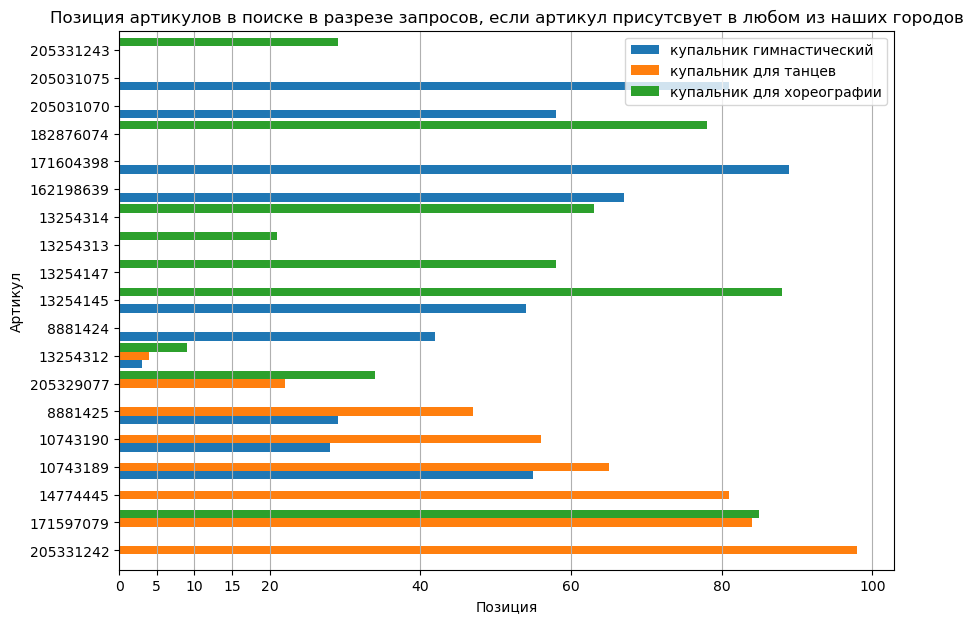

In [17]:
# Пострим линейную гстограмму позиций артикулов в поиске в разрезе запросов
table_query.sort_values('купальник для танцев', ascending=False).plot(kind='barh',
                  x='id',
                  y=table_query.columns[1:].tolist(),
                  figsize=(10,7),
                  legend=True,
                  width=0.9
)
plt.title('Позиция артикулов в поиске в разрезе запросов, если артикул присутсвует в любом из наших городов')
plt.xlabel('Позиция')
plt.ylabel('Артикул')
plt.legend(loc='best')
plt.grid(axis='x')
plt.xticks([0,5,10,15,20,40,60,80,100]) 
plt.show()

<div style="border: 2px solid #ccc; padding: 10px; border-radius: 5px;"> Из гистограммы, представленной выше, можно увидеть, как в среднем меняется позиция в поиске для каждого артикула бренда в зависимости от запроса, введенного покупателем в поисковой строке ВБ. Какой-нибудь артикул может не показываться по определенному запросу, и на это стоит обратить внимание. Подробнее цифры можно изучить в 'Сводная таблица позиций в поиске в зависимости от запроса', которая представлена выше.

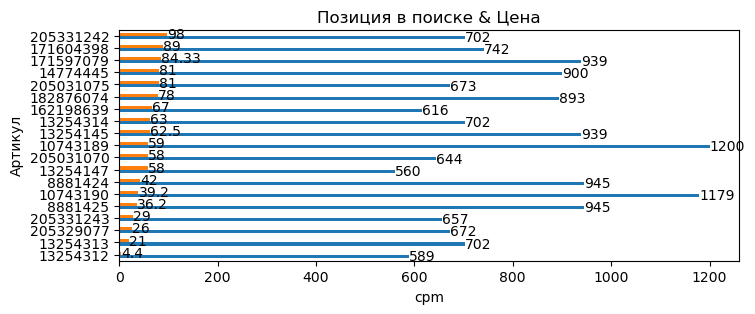

In [10]:
# Пострим линейную гстограмму по цене 
#try:
ax=table_price.sort_values('position').plot(kind='barh',
              x='id',
              y= ['price', 'position'],
              figsize=(8,3),
              legend=False,
              rot=0
)
plt.title('Позиция в поиске & Цена')

plt.xlabel('cpm')
plt.ylabel('Артикул')
plt.bar_label(ax.containers[0]) 
plt.bar_label(ax.containers[1])
plt.show()


<div style="border: 2px solid #ccc; padding: 10px; border-radius: 5px;"> Гистограмма, представленная выше, отражает цены артикулов и место в поиске, для того, чтобы посмотреть визуально, есть ли связь между ценой и местом в поиске.

## Динамический анализ данных

<div style="border: 2px solid #ccc; padding: 10px; border-radius: 5px;"> На основании кода выше был написан гугл скрипт. Каждый час данные автоматизировано складывались в гугл таблицу. По открытому API вб с автоматическими запросами доступны данные только для Москвы. Дальнейший анализ выполнен на основании этого датасета за 3 полных дня (05.10.2025-07.10.2025).

In [11]:
# Импортируем данные из таблицы и выведем первые 5 строк
df_post=''
url = 'https://docs.google.com/spreadsheets/d/1WPd--MqyEQJCCRjFjJxLjAFDOupccu4DYq8at6xXbMg/export?format=csv'
df_post = pd.read_csv(url)
df_post.columns=['datetime', 'query', 'city', 'position', 'id', 'name', 'size', 'price']
df_post['datetime'] = pd.to_datetime(df_post['datetime'], format='%d.%m.%Y %H:%M:%S')
df_post['date']=df_post['datetime'].dt.date
df_post['time'] = df_post['datetime'].dt.floor('h').dt.time
df_post.head()

,datetime,query,city,position,id,name,size,price,date,time
0,2025-10-04 17:28:03,купальник для танцев,Москва,3,13254312,Купальник гимнастический шортами,104,565,2025-10-04,17:00:00
1,2025-10-04 17:28:03,купальник для танцев,Москва,3,13254312,Купальник гимнастический шортами,110,565,2025-10-04,17:00:00
2,2025-10-04 17:28:03,купальник для танцев,Москва,3,13254312,Купальник гимнастический шортами,116,565,2025-10-04,17:00:00
3,2025-10-04 17:28:03,купальник для танцев,Москва,3,13254312,Купальник гимнастический шортами,122-128,565,2025-10-04,17:00:00
4,2025-10-04 17:28:03,купальник для танцев,Москва,3,13254312,Купальник гимнастический шортами,134,565,2025-10-04,17:00:00


In [12]:
# группируем данные по запросу, артикулу, дате и часу
df_pos_group=df_post.groupby(['date','time','query','id'])[['position','price']].mean().reset_index()
df_pos_group[['position','price']] = df_pos_group[['position','price']].astype(int)
list_id=df_pos_group.sort_values('position')['id'].unique()

Как меняется позиция в поиске по артикулам и запросам в течение 24 часов в разрезе трех дней


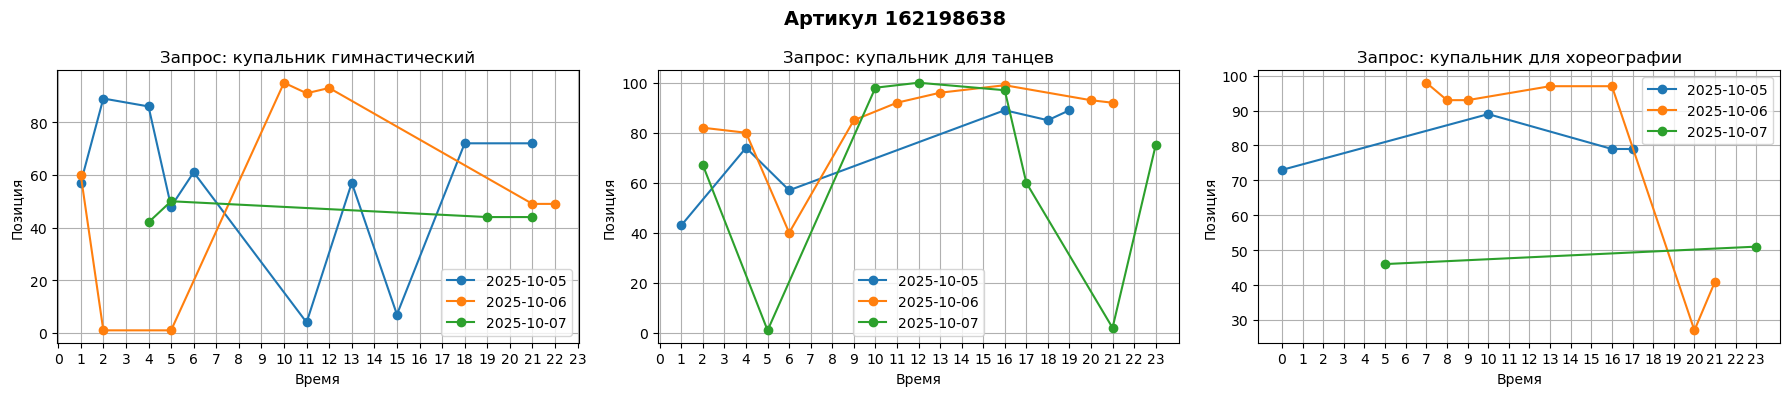

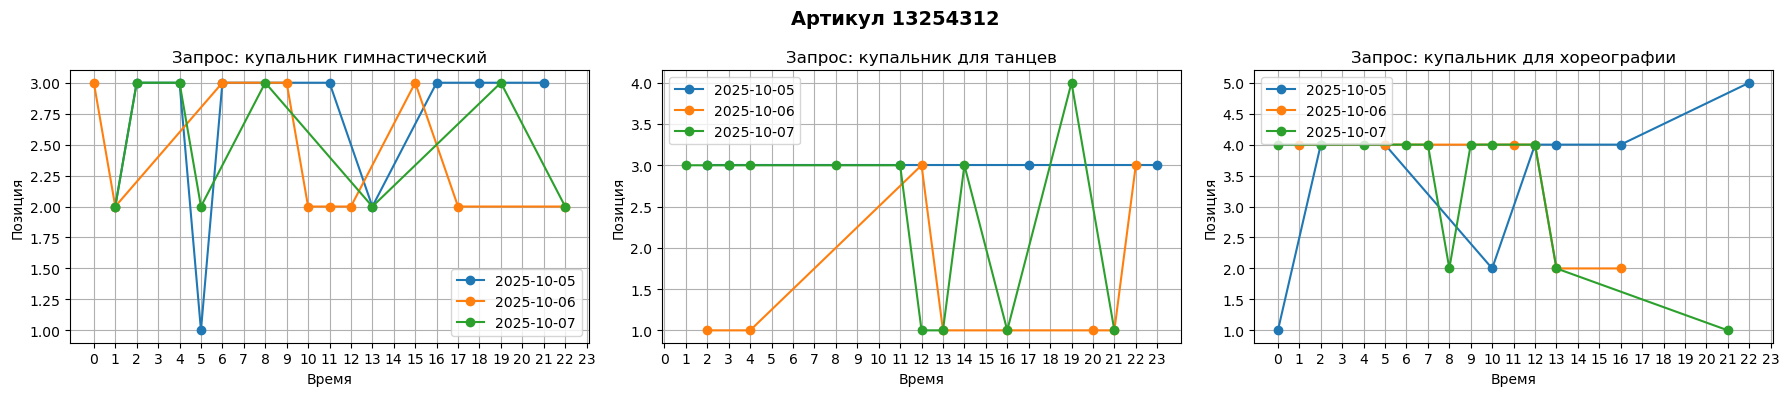

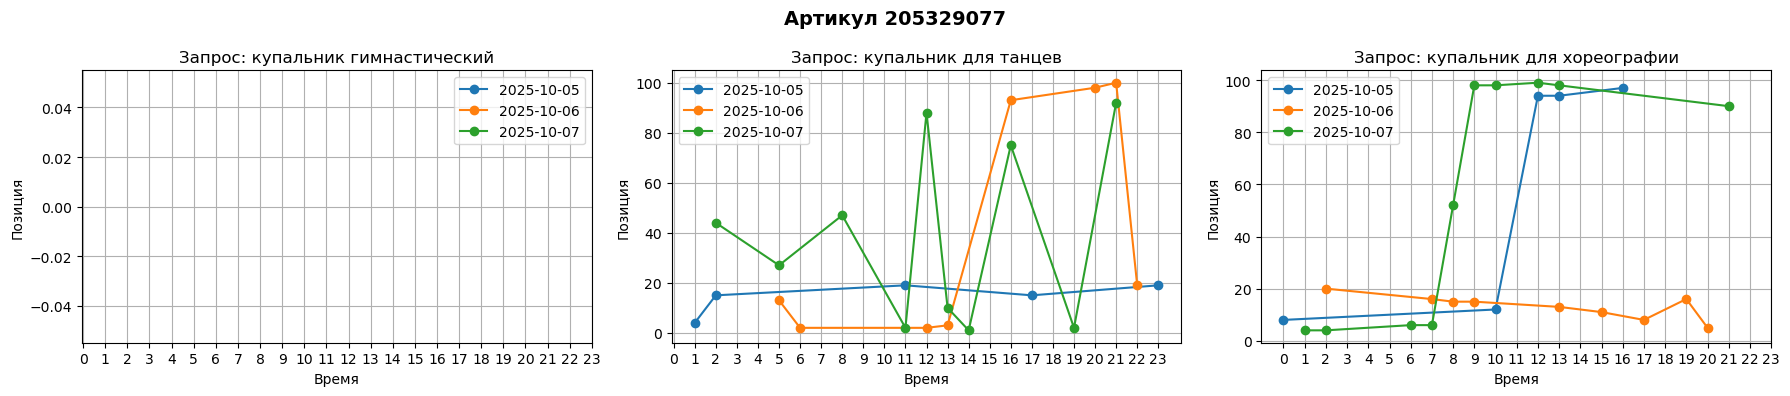

In [13]:
# строим график 
print('\033[1mКак меняется позиция в поиске по артикулам и запросам в течение 24 часов в разрезе трех дней\033[0m')
dates = pd.date_range(start='2025-10-05', end='2025-10-07', freq='D').date.tolist()
for id_ in list_id[0:3]:
    df_pos_group1 = df_pos_group[df_pos_group['id'] == id_]
    print('='*150)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))  # 1 строка, 3 столбца
    fig.suptitle(f'Артикул {id_}', fontsize=14, fontweight='bold')
    
    for i, que in enumerate(query_list):  # enumerate дает индекс i для каждого запроса
        df_pos_group2 = df_pos_group1[df_pos_group1['query'] == que]
       
        for date in dates:  
            data = df_pos_group2[df_pos_group2['date'] == date]
            hours = [t.hour for t in data['time']]
            axes[i].plot(hours, data['position'], marker='o', label=date)
        
        axes[i].set_xlabel('Время')
        axes[i].set_ylabel('Позиция')
        axes[i].set_title(f'Запрос: {que}')
        axes[i].legend()
        axes[i].grid(True)
        axes[i].set_xticks(range(0, 24))
        
    plt.tight_layout()  
    plt.show()
    plt.close()

<div style="border: 2px solid #ccc; padding: 10px; border-radius: 5px;"> На графике выше наглядно видна динамика в течение дня,  для некоторых арт происходят сильные изменения позиции: они могут падать, вылетать  вообще с первых 100 мест, с конкретных запросов. Также можно сравнить как позиции различаются в каждый из 3 дней и одинаковый ли тренд в течении дня у одного артикула, но по разным запросам. Есть товары, которые поднимаютсяв поиске в ночное время, днем снова падают. Данные (для экономии места) представлены только по 3 артикулам, занимающим верхние места в поиске.

 Позиции в поиске для артикулов с максимальным изменением в течении дня за 06.10.2025


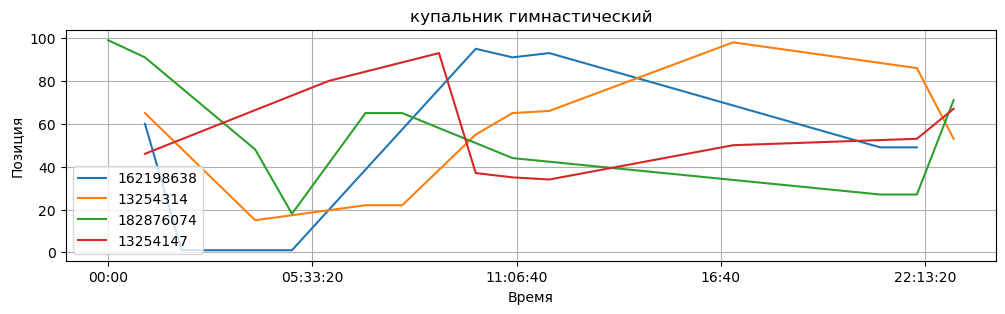

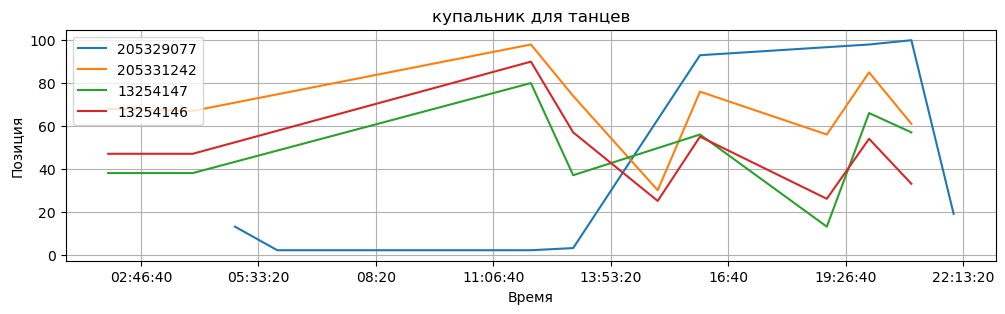

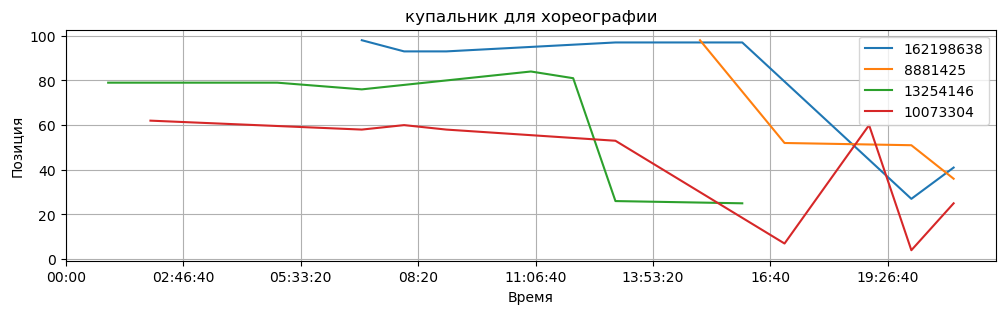

In [14]:
print('\033[1m Позиции в поиске для артикулов с максимальным изменением в течении дня за 06.10.2025\033[0m')
df_day = df_pos_group[df_pos_group['date'].astype(str) == '2025-10-06']
for que in query_list:
    df_day1 = df_day[df_day['query'] == que]
    df_razm=df_day1.groupby('id')['position'].agg(['min','max']).reset_index()
    df_razm['razm']=df_razm['max']-df_razm['min']
    df_razm=df_razm.sort_values('razm', ascending=False)
    list_id_r=df_razm['id'].unique()
    
    plt.figure(figsize=(12, 3))
    
    for id_ in list_id_r[0:4]:
        d = df_day1[df_day1['id'] == id_]
        if len(d) > 0:  # Если есть данные для этого id
            d.plot(kind='line', x='time', y='position', label=id_, ax=plt.gca())
    
    plt.xlabel('Время')
    plt.ylabel('Позиция')
    plt.title(que)
    plt.grid(True)
    plt.show()
    plt.close()

<div style="border: 2px solid #ccc; padding: 10px; border-radius: 5px;"> Графики выше демонстрируют изменения во времени в течении 1 дня по разным запросам, в данный набор попадают 4 артикула с максимльным изменением в поиске. Резкий отброс вниз поиска может свидетельствовать о том, что арт на определенное время вылетает из рекламных позиций, на это стоит обратить внимание. 